## Module 2: Mineral-Machine Learning (MIN-ML)

In [1]:
""" Created on June 30, 2023 // @author: Sarah Shi """

' Created on June 30, 2023 // @author: Sarah Shi '

### I. Introduction

#### Motivations for Applying Machine Learning to Mineral Data 

Explorations of mineral compositions aiming to reveal complex magmatic processes in melts have proliferated with the growing accessibility of geochemical datasets through databases including PetDB, LEPR/TraceDs, and GEOROC and of computational methods [1]. The generation and continuous quality assurance of mineral data in these databases requires significant human intervention and individual post-processing. One major problem is that minerals may be misclassified (i.e., a compiled dataset of clinopyroxenes may contain some amphiboles), and compilations may contain poor-quality electron microprobe (EPMA) analyses (with low totals, low cation sums, or poor correspondence to the theoretical stoichiometry of a mineral phase). At the moment, individual studies compiling geochemical datasets for specific tectonic settings [2] or calibrating thermobarometers based on mineral-melt equilibrium [3] tend to apply their own filters. With a push for a more consistent approach, we create a new open-source Python package called MIN-ML (MINeral classification using Machine Learning) for classifying common igneous minerals based on oxide data collected by EPMA, with functions for calculating stoichiometries and crystallographic sites based on this classification. Utilizing this package allows for the identification of misclassified mineral phases and poor-quality data. We streamline data processing and cleaning to allow for the rapid transition to usable data, improving the utility of data curated in these databases and furthering computing and modeling capabilities. 

While mineral identification and classification are obviously critical to the success of computational methodologies and machine learning (ML) applied to these large datasets, the question of how to best classify minerals from EPMA analyses comes to the fore. We approach this question by exploring and developing ML workflows, both supervised (classification algorithms) and unsupervised (dimensionality reduction and clustering). Unsupervised methods including autoencoders, a type of artificial neural network, present the opportunity to classify minerals with little a priori information. Autoencoders pair two neural networks with an encoder, compressing input data to a dimensionality-reduced latent representation, and a decoder, expanding latent representations to reconstruct the input and minimize loss. We present a novel autoencoder model aimed at meaningfully representing EPMA analyses of minerals in latent space, investigating the relationships between mineral phases, and performing classifications of these minerals. The model is trained with newly compiled datasets of twelve igneous mineral phases on thousands to tens of thousands of analyses per phase – across tectonic settings to train these ML models. The autoencoder is applied to datasets of mineral analyses from PetDB, LEPR, and GEOROC to evaluate model performance and show significant improvements in mineral phase segregation and classification, critical to rigorous dataset quality control and future integration into data processing routines. 

[1] Lehnert, K. A., et al., 2022, IEDA2: Evolving EarthChem, LEPR/TraceDs, and SESAR into a Next Generation Data Infrastructure for Data-Driven Research Paradigms in Geochemistry, Petrology, and Volcanology, in 2022 Goldschmidt Conference.

[2] Gale, A., et al., The mean composition of ocean ridge basalts. Geochemistry, Geophysics, Geosystems 14, 489-518 (2013).

[3] Petrelli, M., et al., Machine learning thermobarometry: Application to clinopyroxene-bearing magmas. JGR: Solid Earth 125, e2020JB020130 (2020).



### II. Accessing GEOROC mineral data with simple coding. 

### What am I looking at here? ###
This is a Jupyter Notebook, a document in a web browser that you can edit, generate text, and run code (typically Python). In this particular case, to help the code run smoothly, we are doing the processing in the cloud using a tool called Google Colab. This means that you should be able to access all of the packages required and execute the code independent of the details of the computer that you are using locally - all you need is access to an internet connection and a web browser.


### Online Big Data - Mineral compositions ###
A key feature of modern earth and environmental sciences is that huge observational, experimental and thermodynamic datasets are now available. The IEDA2 data infrastructures hosts observational datasets with EarthChem and experimental and thermodynamic datasets with LEPR/TraceDs (Library of Experimental Phase Relations/Trace element Distribution experimental database). The GEOROC databases similarly hosts large datasets of petrologic data. Tools like Python allow for increased interaction with these datasets. In this practical we will look at a GEOROC dataset of electron microprobe analyses of minerals, which you can find on [GEOROC](https://doi.org/10.25625/SGFTFN). I take a subset of the full 856k dataset (20%) to make the data a bit more tractable. You can click on the links to understand the data sources. 

We focus on igneous minerals for this study, and thus we limit the mineral analyses to: 

- Amphibole
- Apatite
- Biotite
- Clinopyroxene
- Garnet
- Ilmenite
- K-Feldspar
- Magnetite
- Muscovite
- Olivine 
- Orthopyroxene
- Plagioclase
- Quartz
- Rutile
- Spinel 
- Tourmaline 
- Zircon 

### NumPy for simple maths, Pandas for data-tables ###
We will explore simple chemical relationships in the data using [numpy](https://numpy.org/) to perform simple mathematical calculations and using [pandas](https://pandas.pydata.org/) to read in data. We will use [matplotlib](https://matplotlib.org/) and [seaborn](https://seaborn.pydata.org/index.html) to plot. 

I'll put a couple of cells of code in below, which you should run, in order to import the correct packages and bathymetry data for use in the practical. 


In [2]:
# Import standard Python packages for math, data, and plotting. 

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from matplotlib import rc
rc('font',**{'size': 14})

### III. Analyze the data. 

##### 1. Open the file you have just downloaded in Excel. Notice the huge amount of data! This is only a subset of the mineral analyses available on GEOROC. Petrologists have definitely been busy!

In [3]:
# Read in the datasets here with the Pandas package. We are storing the data as a dataframe, which is a 2D labeled data structure, like a 2D array or table with rows and columns. 

df = pd.read_csv("https://raw.githubusercontent.com/sarahshi/earthchem-teaching/main/GEOROC_subset.csv")

df

,Unnamed: 0,CITATION,SAMPLE NAME,Mineral,SiO2,TiO2,Al2O3,Cr2O3,FeOt,MnO,MgO,NiO,CaO,Na2O,K2O,P2O5
0,22624,[15624] ÖZDEMIR Y. (2011),samp. 2006112,Magnetite,0.237100,1.866100,1.460600,0.234900,86.739900,0.179300,0.724800,NaN,NaN,NaN,NaN,NaN
1,23786,[19299] MACRIS C. A. (2015),samp. SC-1-66,Orthopyroxene,55.040000,0.170000,4.070000,0.640000,6.602898,0.160000,32.690000,0.090000,0.910000,0.050000,0.01,NaN
2,153410,[23134] AUWERA J. V. (2019),samp. PIC24,Plagioclase,52.930000,0.080000,28.400000,NaN,0.990000,NaN,NaN,NaN,11.900000,4.690000,0.22,NaN
3,12456,[21890] MUNTEANU M. (2017),samp. GJ1616,Ilmenite,0.000000,41.180000,0.202900,0.211700,50.010000,0.319700,4.200000,NaN,0.064000,NaN,NaN,NaN
4,231224,[25387] MOGHADAM H. S. (2021),samp. MB 12-2,Olivine,39.380000,0.000000,0.000000,0.000000,19.280000,0.361000,41.140000,NaN,0.294000,0.000000,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153388,30674,[13472] CLASS C. (2009),samp. GR91-14,Olivine,39.168200,0.010010,NaN,0.016080,9.842850,0.143330,48.673240,0.352500,0.022390,NaN,NaN,NaN
153389,191879,[25927] CAO GUANGYUE (2022),samp. SD13-12,Clinopyroxene,52.470000,0.151000,3.064000,0.014000,10.942000,0.119000,12.504000,NaN,18.341000,0.638000,NaN,NaN
153390,185793,[25586] GOMES A. S. (2022),samp. CA-04,Clinopyroxene,53.183000,0.490000,1.927000,0.198000,10.026000,0.295373,19.583000,0.000000,14.978000,0.218000,0.00,0.0
153391,47857,[25647] MUNOZ B. L. (2022),samp. E383B,Garnet,36.870000,0.110000,20.870000,0.010000,29.116797,11.020000,2.030000,NaN,1.170000,NaN,NaN,NaN


In [4]:
# Visualize the dataset by calling the first 5 rows of data. What information is available?

df.head()


,Unnamed: 0,CITATION,SAMPLE NAME,Mineral,SiO2,TiO2,Al2O3,Cr2O3,FeOt,MnO,MgO,NiO,CaO,Na2O,K2O,P2O5
0,22624,[15624] ÖZDEMIR Y. (2011),samp. 2006112,Magnetite,0.2371,1.8661,1.4606,0.2349,86.739900,0.1793,0.7248,NaN,NaN,NaN,NaN,NaN
1,23786,[19299] MACRIS C. A. (2015),samp. SC-1-66,Orthopyroxene,55.0400,0.1700,4.0700,0.6400,6.602898,0.1600,32.6900,0.09,0.910,0.05,0.01,NaN
2,153410,[23134] AUWERA J. V. (2019),samp. PIC24,Plagioclase,52.9300,0.0800,28.4000,NaN,0.990000,NaN,NaN,NaN,11.900,4.69,0.22,NaN
3,12456,[21890] MUNTEANU M. (2017),samp. GJ1616,Ilmenite,0.0000,41.1800,0.2029,0.2117,50.010000,0.3197,4.2000,NaN,0.064,NaN,NaN,NaN
4,231224,[25387] MOGHADAM H. S. (2021),samp. MB 12-2,Olivine,39.3800,0.0000,0.0000,0.0000,19.280000,0.3610,41.1400,NaN,0.294,0.00,0.00,NaN


In [5]:
# We can print all column names to understand what is available by calling: 

df.columns


Index(['Unnamed: 0', 'CITATION', 'SAMPLE NAME', 'Mineral', 'SiO2', 'TiO2',
       'Al2O3', 'Cr2O3', 'FeOt', 'MnO', 'MgO', 'NiO', 'CaO', 'Na2O', 'K2O',
       'P2O5'],
      dtype='object')

In [6]:
# You can access particular columns of data by referencing them as follows: 

df['SiO2']


0          0.237100
1         55.040000
2         52.930000
3          0.000000
4         39.380000
            ...    
153388    39.168200
153389    52.470000
153390    53.183000
153391    36.870000
153392    51.724015
Name: SiO2, Length: 153393, dtype: float64

Note the presence of NaN (Not a Number) values. These are simply blank values in the Excel file. 

##### 2. Looking at df.head() gives us an indication of the columns present, including the one called 'Mineral', indicating the published mineral class. Let's further understand and visualize the data for each mineral class. 

In [7]:
# We can print the information stored in the 'Mineral' column, by calling: 

df['Mineral']


0             Magnetite
1         Orthopyroxene
2           Plagioclase
3              Ilmenite
4               Olivine
              ...      
153388          Olivine
153389    Clinopyroxene
153390    Clinopyroxene
153391           Garnet
153392    Clinopyroxene
Name: Mineral, Length: 153393, dtype: object

In [8]:
# We only see a few of all available mineral classes, but we can also display all the unique values within the column, by calling: 

df['Mineral'].unique()


array(['Magnetite', 'Orthopyroxene', 'Plagioclase', 'Ilmenite', 'Olivine',
       'Clinopyroxene', 'Garnet', 'Amphibole', 'Biotite', 'Spinel',
       'Apatite', 'KFeldspar', 'Muscovite', 'Quartz', 'Zircon'],
      dtype=object)

In [9]:
# What if we only want to look at the olivine data? We can use Python to subselect a portion of the data as follows: 

ol_df = df[df['Mineral'] == 'Olivine']

ol_df


,Unnamed: 0,CITATION,SAMPLE NAME,Mineral,SiO2,TiO2,Al2O3,Cr2O3,FeOt,MnO,MgO,NiO,CaO,Na2O,K2O,P2O5
4,231224,[25387] MOGHADAM H. S. (2021),samp. MB 12-2,Olivine,39.3800,0.00000,0.0000,0.00000,19.28000,0.36100,41.14000,NaN,0.29400,0.0000,0.000,NaN
5,51481,[15830] WEYER S. (2012),samp. VOG-13,Olivine,40.7600,0.00000,0.0240,0.00000,9.02000,0.19800,49.82000,0.3690,0.04300,NaN,NaN,NaN
10,238141,[25922] CHMYZ L. (2022),samp. JAC03.2,Olivine,41.5000,0.00000,0.0121,0.00000,3.04000,0.27000,55.13000,0.0000,0.04510,0.0098,0.004,NaN
16,49323,[15723] VINET N. (2011),samp. KI88-1-298.1,Olivine,37.4540,0.03400,0.0290,0.00000,25.60700,0.25800,36.41300,0.3010,0.19500,NaN,NaN,NaN
18,196848,[23864] ROSTAMI-HOSSOURI M. (2020),samp. OS-3,Olivine,37.3830,NaN,NaN,NaN,25.42700,0.49100,37.91500,0.2190,0.44700,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153371,115811,[19998] VICCARO M. (2016),samp. E8,Olivine,38.5300,0.17000,0.0900,NaN,18.21000,0.45000,41.47000,0.3200,0.37000,0.2700,0.100,NaN
153376,157172,[21888] KAHL M. (2017),samp. 1-8,Olivine,38.3784,NaN,NaN,0.00190,23.17820,0.49210,38.80080,0.0073,0.33900,NaN,NaN,NaN
153377,54780,[16480] BAPTISTE V. (2012),samp. KBJ52,Olivine,41.1528,0.00000,0.0000,0.00460,6.89870,0.06400,51.50330,0.4446,0.00990,0.0109,0.000,NaN
153379,104652,[19950] KAHL M. (2015),samp. 5SE06,Olivine,38.0331,NaN,NaN,NaN,26.02200,0.60560,35.12230,0.0293,0.37500,NaN,NaN,NaN


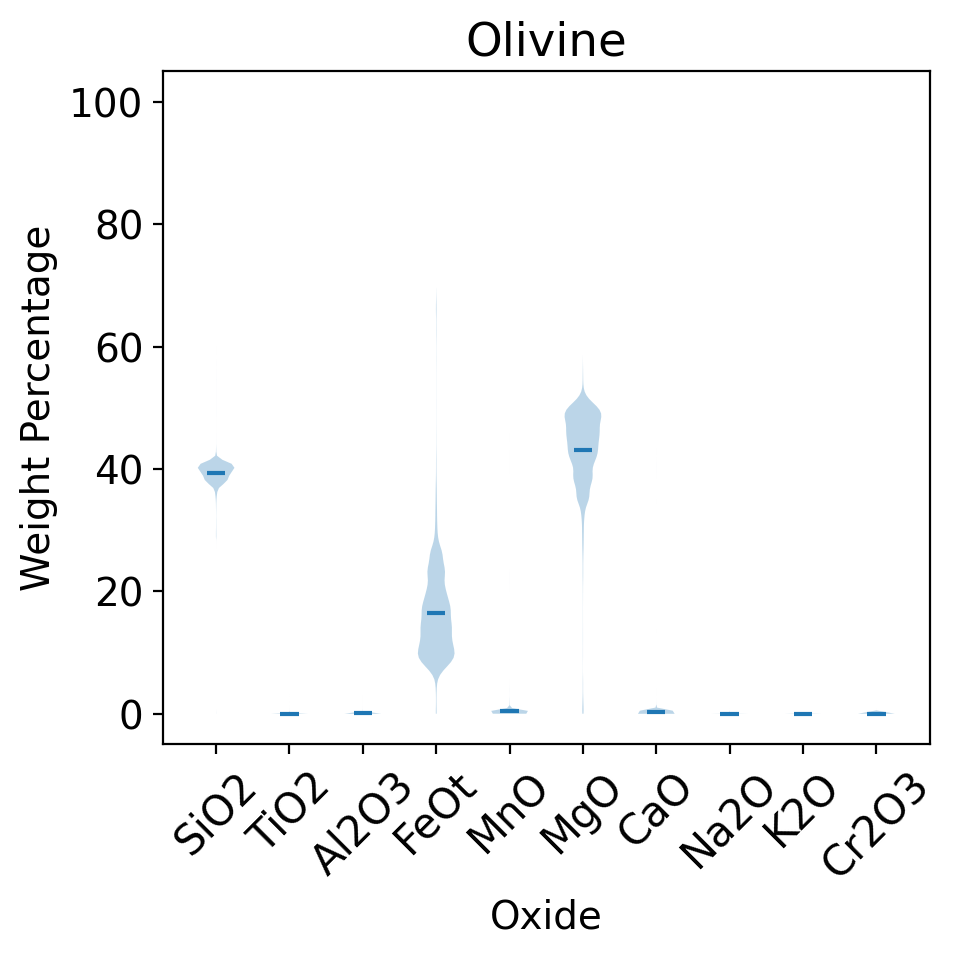

In [10]:
# Let's plot up these oxide distributions with a violin plot. 

oxides = ['SiO2', 'TiO2', 'Al2O3', 'FeOt', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'Cr2O3']

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.violinplot(ol_df[oxides].fillna(0), positions = np.linspace(0, 9, 10), showmeans = True, showextrema= False)
ax.set_title('Olivine')
ax.set_xlabel('Oxide')
ax.set_ylabel('Weight Percentage')
ax.set_xticks(np.linspace(0, 9, 10))
ax.set_xticklabels(oxides, rotation = 45, fontsize = 15)
ax.set_ylim([-5, 105])
plt.tight_layout()
plt.show()


##### 3. Olivine contains primarily $SiO_2$, $FeO$, and $MgO$ as expected. This is great to visualize, but how do we analyze the entire dataset at the same time? What if I want to automate making violin plots for every mineral, instead of subsetting and creating a different figure each time? 


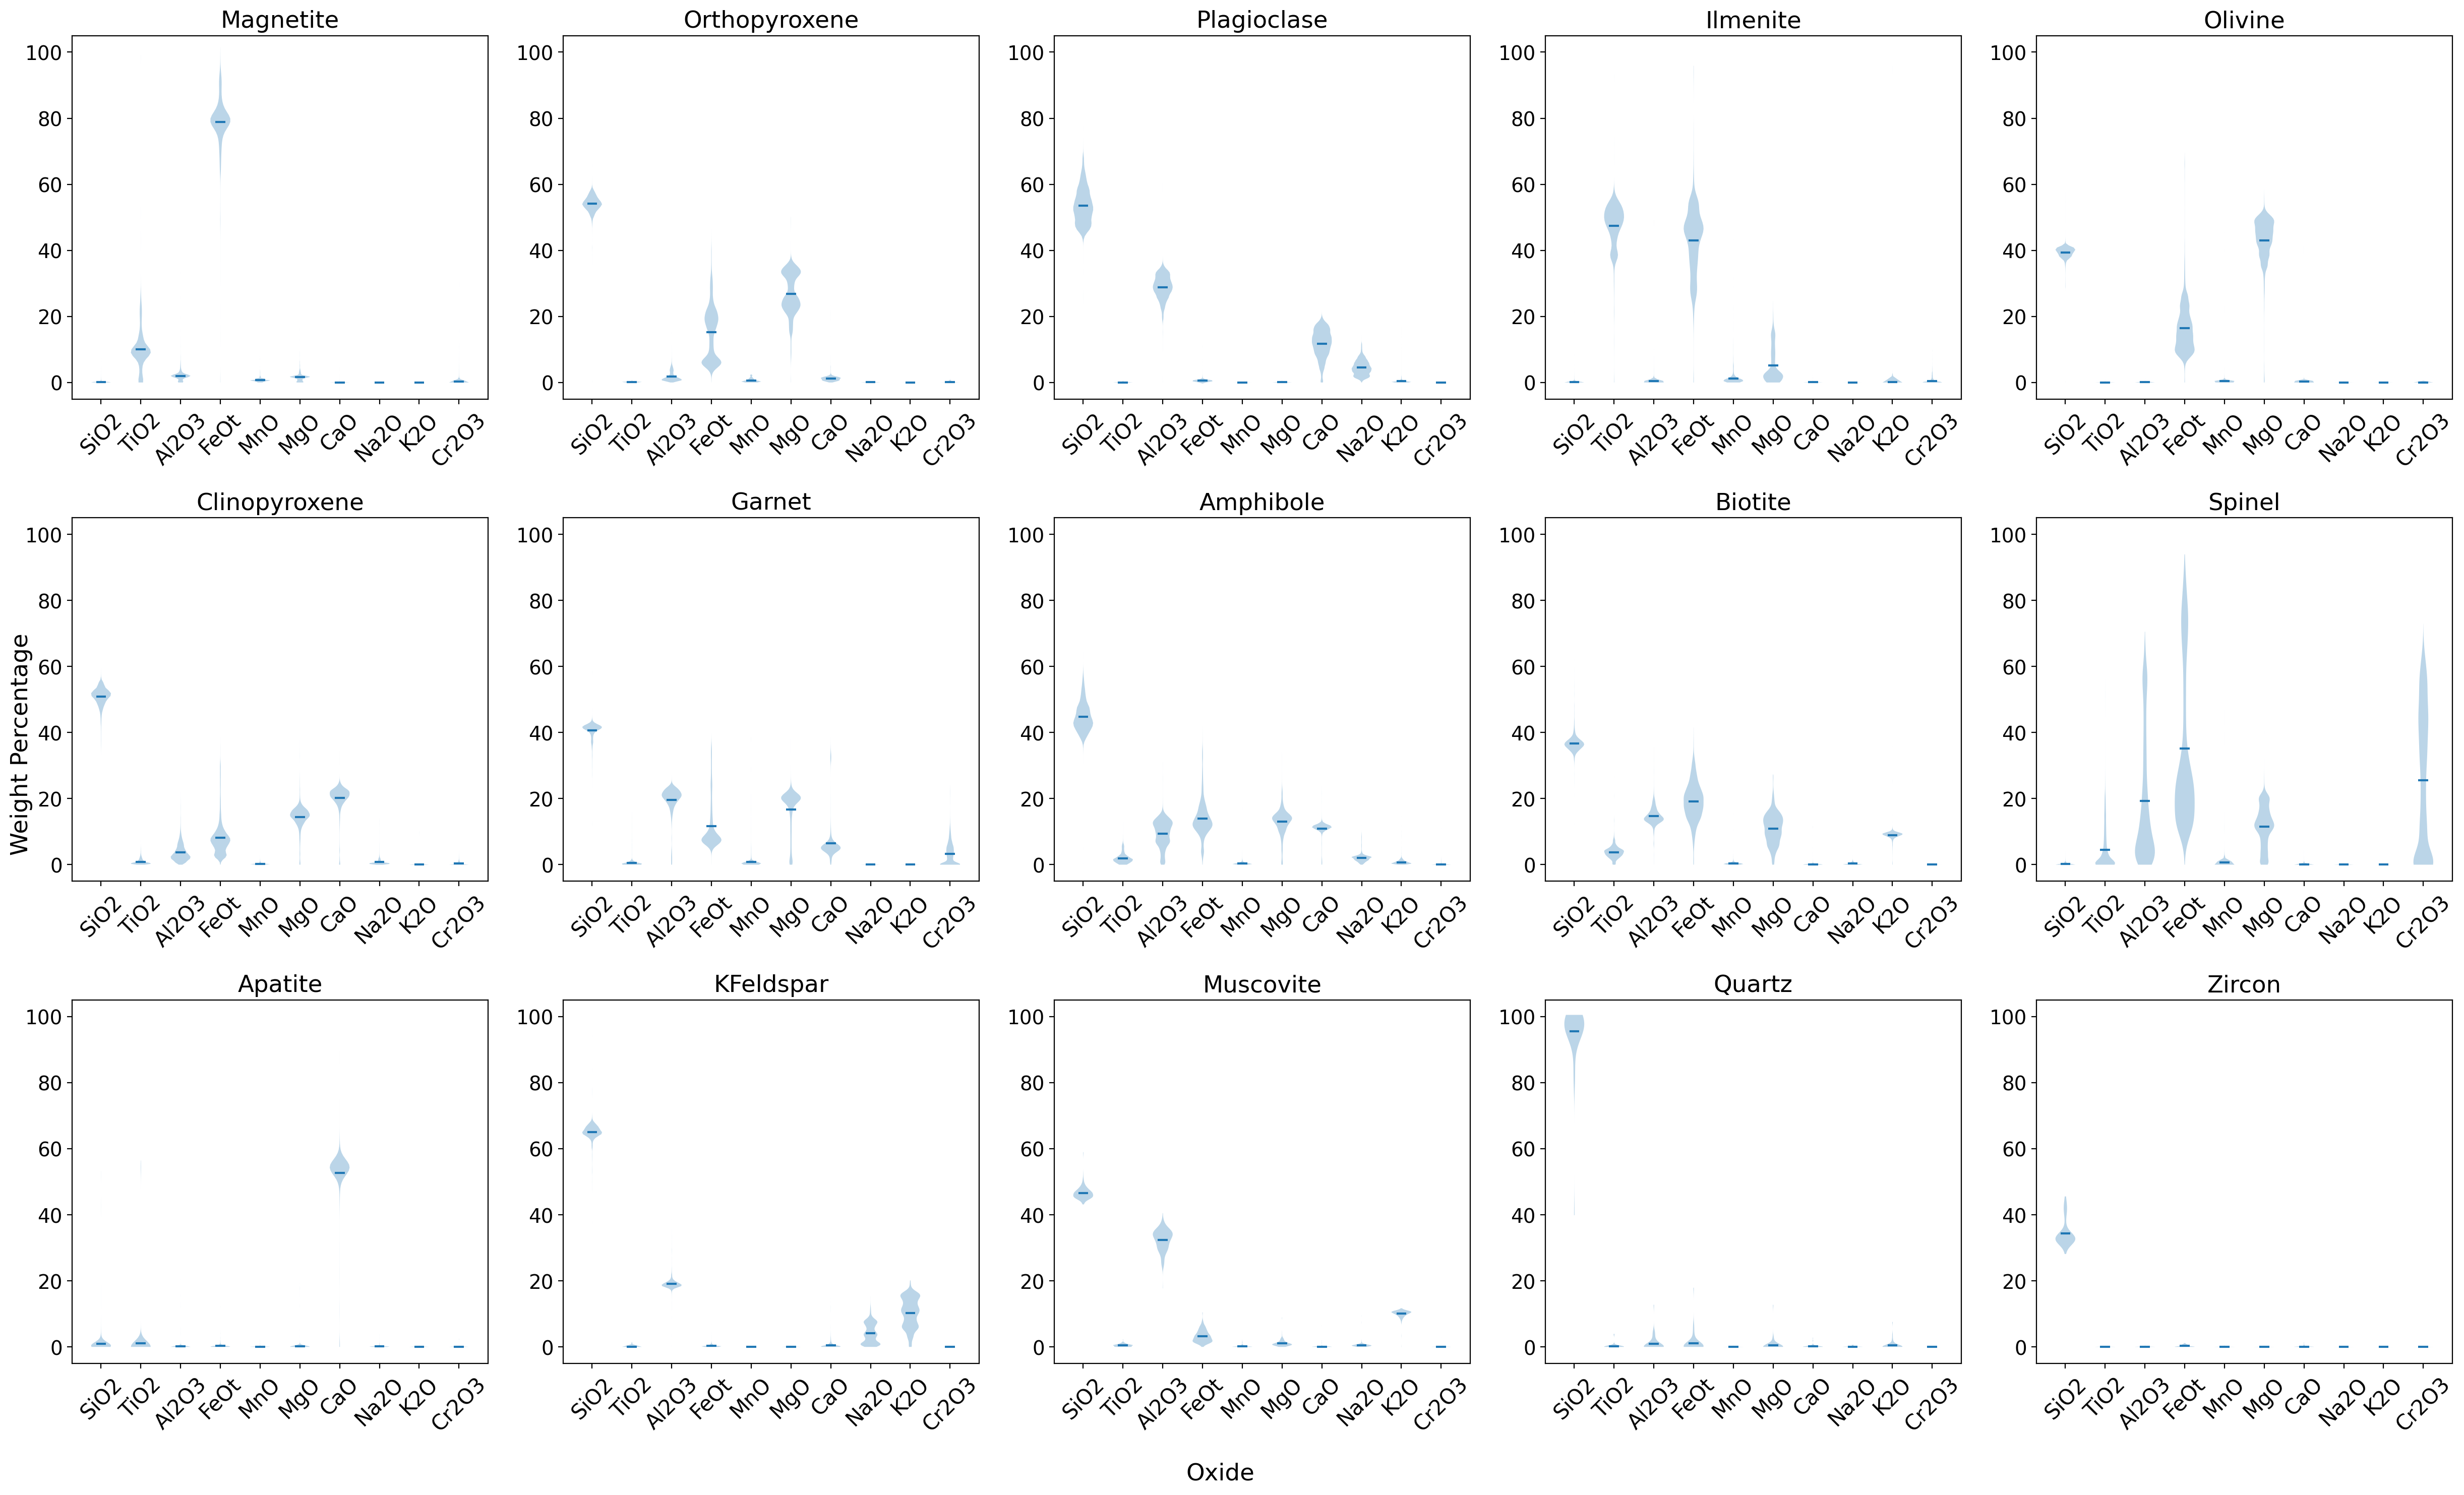

In [11]:
phase = df['Mineral'].unique()

fig, ax = plt.subplots(3, 5, figsize=(25, 15))
ax = ax.flatten()
for i in range(len(phase)): 
    if (df['Mineral'] == phase[i]).sum() > 0:
        ax[i].violinplot(df[df['Mineral']==phase[i]][oxides].fillna(0), positions = np.linspace(0, 9, 10), showmeans = True, showextrema= False)
        ax[i].set_title(phase[i])
        ax[i].set_xticks(np.linspace(0, 9, 10))
        ax[i].set_xticklabels(oxides, rotation = 45, fontsize = 15)
        ax[i].set_ylim([-5, 105])

fig.supylabel('Weight Percentage')
fig.supxlabel('Oxide')
plt.tight_layout()


### IV. Model the data. 

Our goal is to classify minerals from the geochemistry. We can take a twofold approach: 

- Supervised: We assume prior knowledge of the mineral phase label. We see how algorithms can learn to classify things properly. 
- Unsupervised: We assume no prior knowledge of the mineral phase label. We see what patterns come out of the data. 


##### 1. Supervised Learning with Gaussian Discriminant Analysis

We can appreciate that each mineral has distinct oxide composition distributions, usually normally distributed (potentially with long tails). The two minerals that are the most chemically similar are amphibole and clinopyroxene. The geochemical similarity between amphibole and clinopyroxene is well known, often leading petrologists to mistake the two minerals. 

[Gaussian Discriminant Analysis (GDA)](https://www.eecs189.org/static/notes/n18.pdf) is one way in which multivariate Gaussian distributions of features can be modeled, assuming uniqueness. The link contains some excellent information on the math behind GDA. Let's apply GDA to this dataset! We will do this by hand rather than using a Python package, to better understand the methodology. 


In [12]:
# Let's pull a portion to serve as our training dataset -- what the model is calibrated upon. 

from sklearn.model_selection import train_test_split

df_train, testing = train_test_split(df, train_size=0.5, shuffle=True, random_state=42)

df_train

# Normally, we would perform a closer analysis of the data in the training dataset, but this module is more about presenting this methodology rather than about the specifics of these data. 


,Unnamed: 0,CITATION,SAMPLE NAME,Mineral,SiO2,TiO2,Al2O3,Cr2O3,FeOt,MnO,MgO,NiO,CaO,Na2O,K2O,P2O5
90029,120183,[23035] COOPER G. F. (2019),samp. EU 59,Clinopyroxene,48.5560,0.8630,5.7420,0.020,6.7690,0.1180,14.4230,NaN,23.1900,0.213,NaN,NaN
142255,36479,[23994] AZADBAKHT Z. (2020),samp. WX85NB-46,Biotite,30.8500,5.1300,15.0200,NaN,21.2000,0.6300,6.6300,NaN,5.0800,0.217,7.9400,NaN
147194,221266,[24749] GLEESON M. L. M. (2020),samp. 17MMSG16,Olivine,39.2876,NaN,0.0254,NaN,14.8183,0.2417,44.3088,0.2765,0.0881,NaN,NaN,NaN
107147,41134,[15018] ROWE M. C. (2011),samp. 07-025,Olivine,39.0389,0.0205,0.7352,0.000,17.6945,0.2957,42.2343,0.1419,0.1898,0.000,0.0048,NaN
103369,179073,[25493] PONTESILLI A. (2021),samp. DVB10,Clinopyroxene,47.1300,2.3500,4.7400,0.310,8.1200,0.2100,12.9700,NaN,21.5100,0.540,0.0600,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,172416,[22666] JANKOVICS M. E. (2019),samp. L4,Olivine,38.7380,0.0260,0.0480,0.042,18.9090,0.3370,41.3280,0.1130,0.2760,NaN,NaN,0.081
103694,34503,[13985] FRANZ L. (2010),samp. 35GTVA1,Olivine,40.6100,0.0100,0.0100,0.040,8.8200,0.0900,50.6300,0.4400,0.0500,NaN,NaN,NaN
131932,8822,[13943] HIN R. C. (2009),samp. ATT1119,Garnet,42.1000,0.2800,18.8000,5.260,6.4400,0.2700,20.8000,NaN,5.2100,0.020,NaN,NaN
146867,189136,[23439] PINTO V. M. (2019),samp. TG62-17,Olivine,39.5640,0.0230,0.0000,0.091,15.6420,NaN,45.1460,0.2960,0.2800,NaN,NaN,NaN


In [13]:
# We want to analyze the mean and covariance matrices of each mineral class. To do so, let's define a function: 

def mean_cov(df, confidence_interval=0.997):
    oxides = ['SiO2', 'TiO2', 'Al2O3', 'FeOt', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'Cr2O3']
    data = df[oxides].values

    # Calculate mean and covariance matrix
    mean = np.mean(data, axis=0)
    cov = np.cov(data, rowvar=False)

    return mean, cov


In [14]:
# Computing the mean and covariance. The mean_cov function calculates the mean and covariance matrix for a given subset of the dataset, which represents the feature statistics for each class.

amp_mean, amp_cov = mean_cov(df_train[df_train.Mineral=='Amphibole'].fillna(0))
ap_mean, ap_cov = mean_cov(df_train[df_train.Mineral=='Apatite'].fillna(0))
bt_mean, bt_cov = mean_cov(df_train[df_train.Mineral=='Biotite'].fillna(0))
cpx_mean, cpx_cov = mean_cov(df_train[df_train.Mineral=='Clinopyroxene'].fillna(0))
gt_mean, gt_cov = mean_cov(df_train[df_train.Mineral=='Garnet'].fillna(0))
il_mean, il_cov = mean_cov(df_train[df_train.Mineral=='Ilmenite'].fillna(0))
ksp_mean, ksp_cov = mean_cov(df_train[df_train.Mineral=='KFeldspar'].fillna(0))
ms_mean, ms_cov = mean_cov(df_train[df_train.Mineral=='Magnetite'].fillna(0))
ol_mean, ol_cov = mean_cov(df_train[df_train.Mineral=='Olivine'].fillna(0))
opx_mean, opx_cov = mean_cov(df_train[df_train.Mineral=='Orthopyroxene'].fillna(0))
plag_mean, plag_cov = mean_cov(df_train[df_train.Mineral=='Plagioclase'].fillna(0))
qtz_mean, qtz_cov = mean_cov(df_train[df_train.Mineral=='Quartz'].fillna(0))
sp_mean, sp_cov = mean_cov(df_train[df_train.Mineral=='Spinel'].fillna(0))
zr_mean, zr_cov = mean_cov(df_train[df_train.Mineral=='Zircon'].fillna(0))


In [15]:
# Create multivariate normal distributions: The multivariate_normal function is used to create a multivariate normal distribution for each class. 
# The mean and covariance matrix obtained in the previous step are used as parameters for these distributions.

from scipy.stats import multivariate_normal

amp_rv = multivariate_normal(amp_mean, amp_cov, allow_singular=True)
ap_rv = multivariate_normal(ap_mean, ap_cov, allow_singular=True)
bt_rv = multivariate_normal(bt_mean, bt_cov, allow_singular=True)
cpx_rv = multivariate_normal(cpx_mean, cpx_cov, allow_singular=True)
gt_rv = multivariate_normal(gt_mean, gt_cov, allow_singular=True)
il_rv = multivariate_normal(il_mean, il_cov, allow_singular=True)
ksp_rv = multivariate_normal(ksp_mean, ksp_cov, allow_singular=True)
ms_rv = multivariate_normal(ms_mean, ms_cov, allow_singular=True)
ol_rv = multivariate_normal(ol_mean, ol_cov, allow_singular=True)
opx_rv = multivariate_normal(opx_mean, opx_cov, allow_singular=True)
plag_rv = multivariate_normal(plag_mean, plag_cov, allow_singular=True)
qtz_rv = multivariate_normal(qtz_mean, qtz_cov, allow_singular=True)
sp_rv = multivariate_normal(sp_mean, sp_cov, allow_singular=True)
zr_rv = multivariate_normal(zr_mean, zr_cov, allow_singular=True)


In [16]:
# Determining the best fit mineral: The class with the highest probability is selected as the predicted class for the data instance.

# Store all the random variables in a dictionary for easier access
rv_dict = {'Amphibole': amp_rv, 'Apatite': ap_rv, 'Biotite': bt_rv, 'Clinopyroxene': cpx_rv,
           'Garnet': gt_rv, 'Ilmenite': il_rv, 'KFeldspar': ksp_rv, 'Magnetite': ms_rv,
           'Olivine': ol_rv, 'Orthopyroxene': opx_rv, 'Plagioclase': plag_rv, 'Quartz': qtz_rv,
           'Spinel': sp_rv, 'Zircon': zr_rv}

# Define a function that will be applied to each row
def get_best_fit_mineral(row):
    # Calculate the PDF for each distribution and store the results in a dictionary
    probs = {mineral: rv.pdf(row) for mineral, rv in rv_dict.items()}
    
    # Find the mineral with the highest probability
    best_fit_mineral = max(probs, key=probs.get)

    return best_fit_mineral


In [17]:
# We now want to apply this function to a test dataset. We pull some GEOROC data from the Cascades to perform this test. 

df_test = pd.read_csv("https://raw.githubusercontent.com/sarahshi/earthchem-teaching/main/CpxAmp_April23.csv")

# Use the `apply` method to apply the function to each row

df_test['Best-Fit Mineral'] = df_test[oxides].fillna(0).apply(get_best_fit_mineral, axis=1)
df_test


,Sample_ID_Cpx,Mineral,SiO2,TiO2,Al2O3,Cr2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,Total,Best-Fit Mineral
0,TP3_cpx1-1,Clinopyroxene,52.220000,0.5007,3.5300,0.2984,5.3200,0.1401,16.6700,21.6700,0.2527,NaN,100.6019,Clinopyroxene
1,TP3_cpx1-2,Clinopyroxene,52.460000,0.3527,2.5085,0.5776,4.3600,0.0958,16.7800,22.2800,0.2396,NaN,99.6542,Clinopyroxene
2,TP3_cpx2,Clinopyroxene,50.740000,1.0913,2.0027,0.0136,11.6200,0.2940,15.0500,18.0800,0.3272,NaN,99.2188,Clinopyroxene
3,TP4_cpx1-1,Clinopyroxene,51.330000,0.5243,2.5074,0.1629,5.9000,0.1708,16.0700,21.2000,0.2248,NaN,98.0902,Clinopyroxene
4,TP4_cpx1-2,Clinopyroxene,51.780000,0.4274,1.7926,0.0228,7.9100,0.2242,15.4500,21.0400,0.3433,NaN,98.9903,Clinopyroxene
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5636,CC-F-I-13 coreGroundmass,Amphibole,50.756456,0.5793,1.9621,NaN,11.4141,0.6550,13.2942,18.2989,0.3220,0.0459,NaN,Clinopyroxene
5637,CC-F-I-13 coreGroundmass,Amphibole,50.704634,0.6459,4.2237,NaN,10.0572,0.6882,12.9776,18.4196,0.6676,0.1259,NaN,Clinopyroxene
5638,CC-F-I-13 rimGroundmass,Amphibole,53.701120,0.3659,1.1450,NaN,18.0967,0.8098,22.5972,1.9882,0.0340,0.0392,NaN,Orthopyroxene
5639,CC-F-I-13 rimGroundmass,Amphibole,48.867049,1.3069,7.5792,NaN,12.0174,0.4440,13.7267,12.0664,1.3288,0.3254,NaN,Amphibole


In [18]:
# Let's check which values in the dataframe have published and predicted classifications agreeing vs. disagreeing. 

true = df_test[df_test['Mineral']==df_test['Best-Fit Mineral']]
false = df_test[df_test['Mineral']!=df_test['Best-Fit Mineral']]

print(str(len(true)) + ' classifications agree and ' + str(len(false)) + ' classifications disagree')


5460 classifications agree and 181 classifications disagree


In [19]:
true

,Sample_ID_Cpx,Mineral,SiO2,TiO2,Al2O3,Cr2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,Total,Best-Fit Mineral
0,TP3_cpx1-1,Clinopyroxene,52.220000,0.5007,3.5300,0.2984,5.3200,0.1401,16.6700,21.6700,0.2527,NaN,100.6019,Clinopyroxene
1,TP3_cpx1-2,Clinopyroxene,52.460000,0.3527,2.5085,0.5776,4.3600,0.0958,16.7800,22.2800,0.2396,NaN,99.6542,Clinopyroxene
2,TP3_cpx2,Clinopyroxene,50.740000,1.0913,2.0027,0.0136,11.6200,0.2940,15.0500,18.0800,0.3272,NaN,99.2188,Clinopyroxene
3,TP4_cpx1-1,Clinopyroxene,51.330000,0.5243,2.5074,0.1629,5.9000,0.1708,16.0700,21.2000,0.2248,NaN,98.0902,Clinopyroxene
4,TP4_cpx1-2,Clinopyroxene,51.780000,0.4274,1.7926,0.0228,7.9100,0.2242,15.4500,21.0400,0.3433,NaN,98.9903,Clinopyroxene
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5633,CC-F-I-12 rimPhenocryst w/ Opx Rxn Rim,Amphibole,48.792100,1.3812,6.3549,NaN,12.6581,0.5266,15.1560,11.1577,1.6902,0.4533,NaN,Amphibole
5634,CC-F-I-12 rimPhenocryst w/ Opx Rxn Rim,Amphibole,48.801500,1.4368,5.9587,NaN,13.5082,0.3379,15.2143,10.8514,1.4344,0.3679,NaN,Amphibole
5635,CC-F-I-13 coreGroundmass,Amphibole,43.237458,1.9329,12.3612,NaN,13.4128,0.3021,12.2825,10.5433,2.7719,0.4604,NaN,Amphibole
5639,CC-F-I-13 rimGroundmass,Amphibole,48.867049,1.3069,7.5792,NaN,12.0174,0.4440,13.7267,12.0664,1.3288,0.3254,NaN,Amphibole


In [20]:
false

,Sample_ID_Cpx,Mineral,SiO2,TiO2,Al2O3,Cr2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,Total,Best-Fit Mineral
6,CC1_cpx2,Clinopyroxene,48.700000,0.8657,1.5510,0.0059,8.4100,0.3008,15.2400,16.3600,0.4109,NaN,91.8443,Amphibole
14,LS1_cpx2,Clinopyroxene,52.550000,3.7800,8.5900,0.0149,11.9500,0.2641,5.0100,13.7900,1.2640,NaN,97.2130,Amphibole
19,SC4_cpx1,Clinopyroxene,36.380000,2.2063,16.0600,0.0196,7.7000,0.1331,5.9600,16.3600,1.3099,NaN,86.1289,Amphibole
20,SC4_cpx1 (dup),Clinopyroxene,37.030000,2.2841,16.2800,0.0233,7.4100,0.1379,6.1100,16.6900,0.7207,NaN,86.6860,Amphibole
22,PB5_cpx1,Clinopyroxene,40.700000,5.2800,11.8500,0.2834,12.6900,0.1715,11.9000,10.7700,3.4800,NaN,97.1249,Amphibole
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5611,CC-F-I-10 coreGroundmass,Amphibole,52.569636,0.3881,2.2893,NaN,7.9605,0.2545,15.8528,18.9868,0.1495,0.0228,NaN,Clinopyroxene
5612,CC-F-I-10 coreGroundmass,Amphibole,52.347908,0.3661,2.0622,NaN,8.4643,0.3123,16.3525,17.8874,0.1534,0.0275,NaN,Clinopyroxene
5636,CC-F-I-13 coreGroundmass,Amphibole,50.756456,0.5793,1.9621,NaN,11.4141,0.6550,13.2942,18.2989,0.3220,0.0459,NaN,Clinopyroxene
5637,CC-F-I-13 coreGroundmass,Amphibole,50.704634,0.6459,4.2237,NaN,10.0572,0.6882,12.9776,18.4196,0.6676,0.1259,NaN,Clinopyroxene


We can focus on minerals with common misclassifications -- in this case, clinopyroxene and amphibole. 

In [21]:

pubcpx_predcpx = true[(true['Mineral']=='Clinopyroxene') & (true['Best-Fit Mineral']=='Clinopyroxene')]

pubcpx_predamp = false[(false['Mineral']=='Clinopyroxene') & (false['Best-Fit Mineral']=='Amphibole')]

pubcpx_predamp


,Sample_ID_Cpx,Mineral,SiO2,TiO2,Al2O3,Cr2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,Total,Best-Fit Mineral
6,CC1_cpx2,Clinopyroxene,48.7000,0.8657,1.5510,0.0059,8.4100,0.3008,15.2400,16.3600,0.4109,NaN,91.8443,Amphibole
14,LS1_cpx2,Clinopyroxene,52.5500,3.7800,8.5900,0.0149,11.9500,0.2641,5.0100,13.7900,1.2640,NaN,97.2130,Amphibole
19,SC4_cpx1,Clinopyroxene,36.3800,2.2063,16.0600,0.0196,7.7000,0.1331,5.9600,16.3600,1.3099,NaN,86.1289,Amphibole
20,SC4_cpx1 (dup),Clinopyroxene,37.0300,2.2841,16.2800,0.0233,7.4100,0.1379,6.1100,16.6900,0.7207,NaN,86.6860,Amphibole
22,PB5_cpx1,Clinopyroxene,40.7000,5.2800,11.8500,0.2834,12.6900,0.1715,11.9000,10.7700,3.4800,NaN,97.1249,Amphibole
603,MA tephra 5-169,Clinopyroxene,53.8800,0.8180,5.3560,0.0230,11.3260,0.3110,15.2500,10.1170,0.8150,NaN,NaN,Amphibole
868,MA tephra 8-80,Clinopyroxene,50.1030,0.0790,1.2790,0.0000,1.8470,0.3770,13.2180,19.4140,0.3030,NaN,NaN,Amphibole
1350,MA-5 -33,Clinopyroxene,52.3950,0.5140,3.9360,0.0000,12.8650,0.4540,15.0210,12.7150,0.2400,NaN,NaN,Amphibole
1659,NaN,Clinopyroxene,51.7300,0.2000,0.8000,0.0400,13.9400,0.5800,20.0700,9.9800,0.2000,NaN,97.5500,Amphibole
1742,NaN,Clinopyroxene,44.0914,3.0994,10.8363,0.0116,13.5746,0.1663,14.9973,10.2831,2.4718,0.3001,NaN,Amphibole


In [22]:

pubamp_predamp = true[(true['Mineral']=='Amphibole') & (true['Best-Fit Mineral']=='Amphibole')]

pubamp_predcpx = false[(false['Mineral']=='Amphibole') & (false['Best-Fit Mineral']=='Clinopyroxene')]

pubamp_predcpx


,Sample_ID_Cpx,Mineral,SiO2,TiO2,Al2O3,Cr2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,Total,Best-Fit Mineral
3516,NaN,Amphibole,49.080000,2.0300,5.2400,NaN,8.3200,0.2500,13.9300,19.1500,0.5500,0.0100,NaN,Clinopyroxene
4177,MA-94 -19,Amphibole,46.836000,2.0840,5.3860,NaN,10.1590,0.2050,13.0640,20.9980,0.4090,NaN,NaN,Clinopyroxene
5422,CC-B-I-11 RimHeavily Altered Phenocryst,Amphibole,54.455720,0.6255,5.5342,NaN,9.6903,0.4057,12.7070,14.5114,1.1632,0.6666,NaN,Clinopyroxene
5423,CC-C-I-1 CoreHeavily Altered Phenocryst,Amphibole,52.058261,1.0383,1.4759,NaN,9.2032,0.6311,19.9844,12.9576,0.5676,0.0425,NaN,Clinopyroxene
5425,CC-C-I-1 RimGroundmass,Amphibole,51.555402,0.3782,3.0945,NaN,8.0721,0.2632,16.0080,18.1130,0.1103,NaN,NaN,Clinopyroxene
5575,CC-E-I-16 CoreGroundmass,Amphibole,51.444300,0.4427,2.8428,NaN,8.0214,0.2763,15.5518,19.7608,0.2820,0.0149,NaN,Clinopyroxene
5596,CC-E-I-18 coreGroundmass,Amphibole,49.694700,0.7665,4.5886,NaN,7.8395,0.2509,14.0420,20.3571,0.3323,0.0441,NaN,Clinopyroxene
5597,CC-E-I-18 coreMicrophenocryst w/ Opx Rxn Rim,Amphibole,51.317700,0.5165,2.7601,NaN,8.9094,0.6108,16.5187,17.0640,0.2905,0.0255,NaN,Clinopyroxene
5608,CC-F-I-10 coreGroundmass,Amphibole,51.047143,0.4624,1.8447,NaN,10.5081,0.4704,13.7490,19.5891,0.2956,0.0394,NaN,Clinopyroxene
5609,CC-F-I-10 coreGroundmass,Amphibole,50.120353,0.3659,2.5974,NaN,14.6961,0.7687,14.1241,14.0438,0.2218,0.0359,NaN,Clinopyroxene


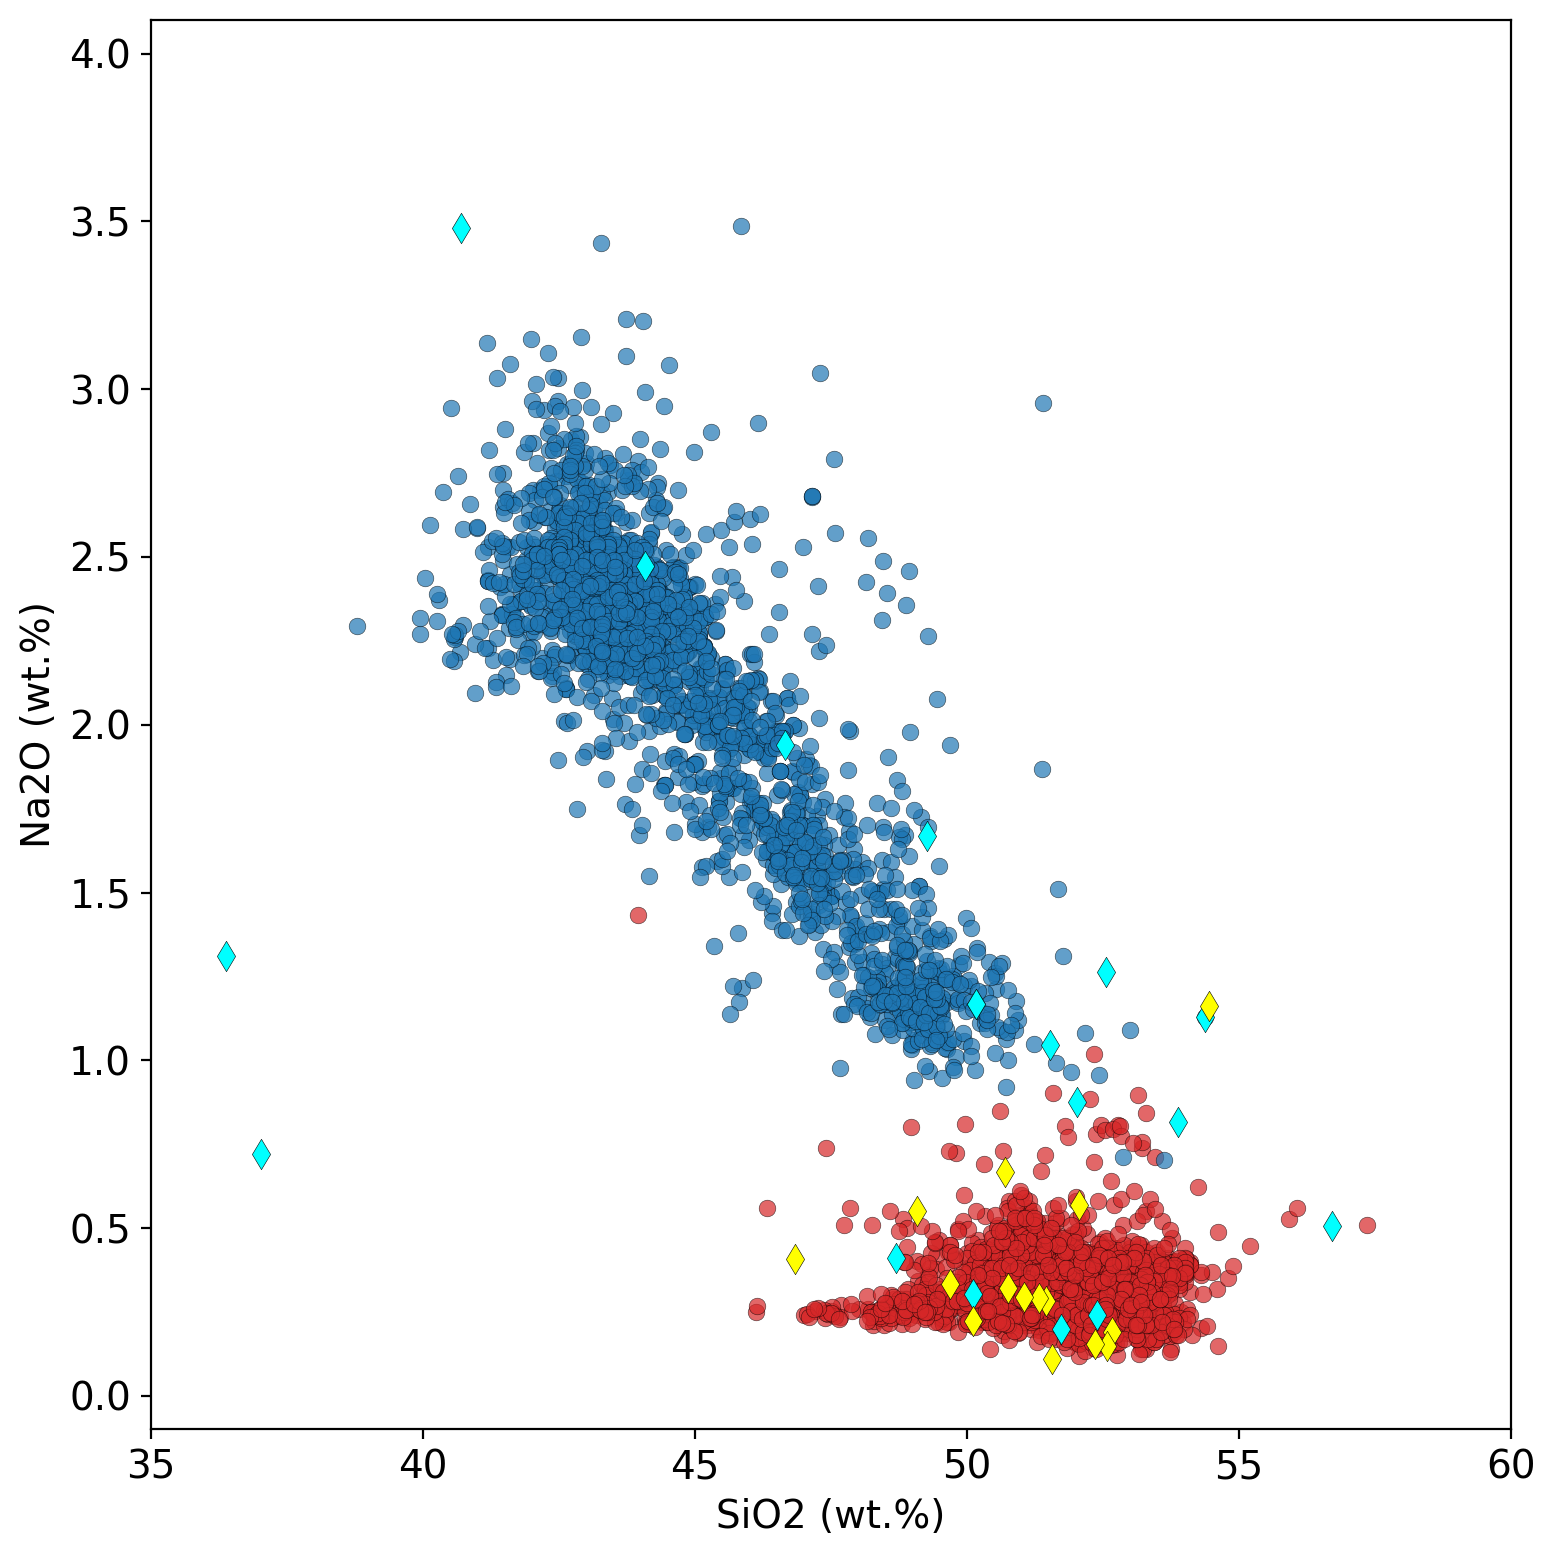

In [23]:

plt.figure(figsize=(8, 8))
plt.scatter(pubcpx_predcpx['SiO2'], pubcpx_predcpx['Na2O'], color='tab:red', linewidth=0.2, ec='k', alpha=0.7, label='Pub:Cpx, GDA:Cpx')
plt.scatter(pubamp_predamp['SiO2'], pubamp_predamp['Na2O'], color='tab:blue', linewidth=0.2, ec='k', alpha=0.7, label='Pub:Amp, GDA:Amp')

plt.scatter(pubcpx_predamp['SiO2'], pubcpx_predamp['Na2O'], color='cyan', marker='d', s=60, linewidth=0.2, ec='k', label='Pub:Cpx, GDA:Amp')
plt.scatter(pubamp_predcpx['SiO2'], pubamp_predcpx['Na2O'], color='yellow', marker='d', s=60, linewidth=0.2, ec='k', label='Pub:Amp, GDA:Cpx')

plt.xlim([35, 60])
plt.ylim([-0.1, 4.1])
plt.xlabel('SiO2 (wt.%)')
plt.ylabel('Na2O (wt.%)')
plt.tight_layout()

##### A. How do predictions from GD compare to predictions from the neural network of the MIN-ML talk? See the results in the following figure:

![minml_class](https://raw.githubusercontent.com/sarahshi/earthchem-teaching/main/figures/minml_class.png)


##### 2. Unsupervised Learning with PCA

Principal Components Analysis (PCA) is a linear transformation that resolves high dimensionality data and constructs principle components, or lower dimensionality representations of interrelated data. PCA constructs a covariance (and sometimes, the correlation) matrix of data and solves this eigenvector/eigenvalue problem to determine the matrix eigenvectors. The principle components, or the eigenvectors corresponding to the largest eigenvalues, thus identify the directions along which the variation in data is maximized in n-dimensional space.

We can apply methods like PCA to glean what patterns exist within the dataset. 


In [24]:
import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

oxides = ['SiO2', 'TiO2', 'Al2O3', 'FeOt', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'Cr2O3']
label = ['Mineral']

min = df_train[label]
wt = df_train[oxides].fillna(0).to_numpy()
# Here, we apply a StandardScaler or z-score normalization to ensure that the oxides have similar numeric ranges. 
wt_scale = StandardScaler().fit_transform(wt)

pca = PCA(n_components = 8)
pca_arr = pca.fit_transform(wt_scale)

print(str(round(pca.explained_variance_ratio_.sum()*100, 2)) + '% of the variability in data is explained by 8 principal components')

98.02% of the variability in data is explained by 8 principal components


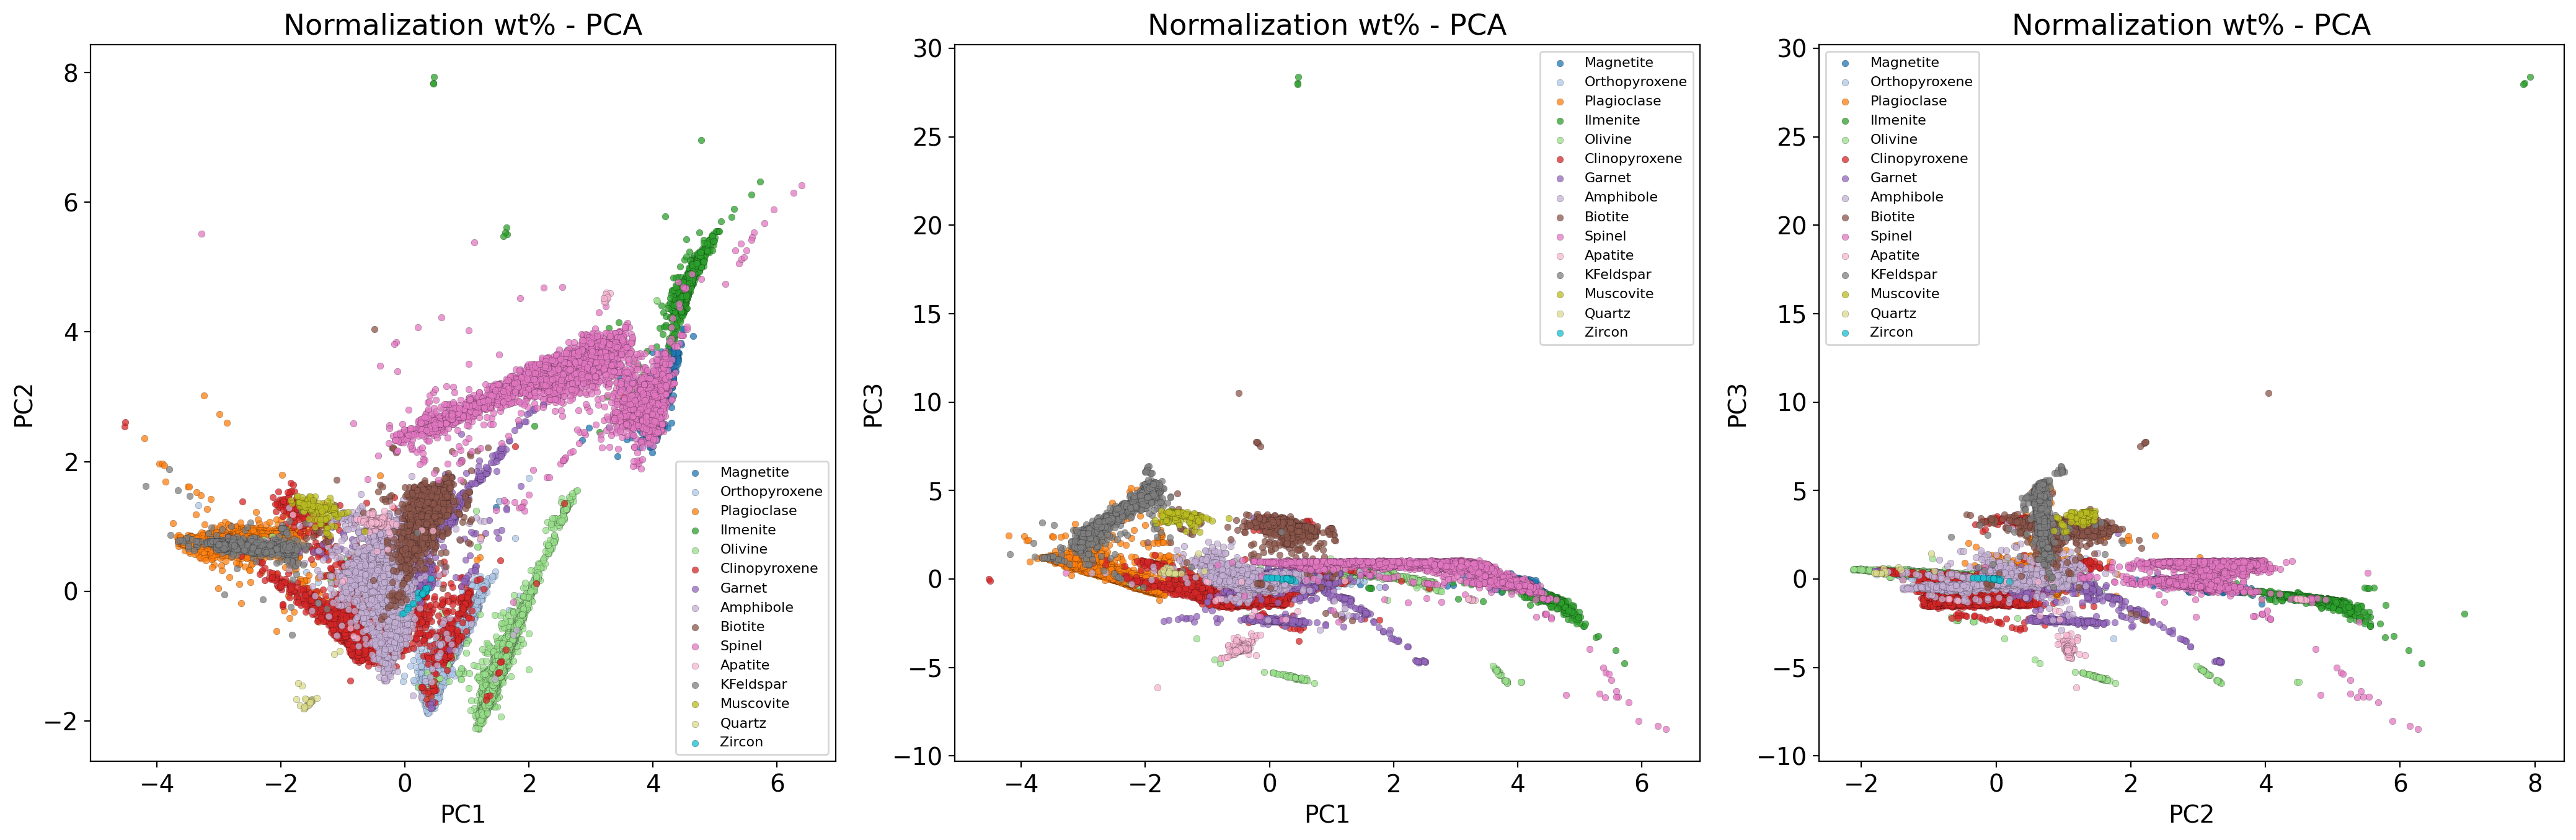

In [25]:
# Let's plot up our PCA results for each mineral class. This code plots the first three principal components and automates the plotting process.  

import matplotlib.colors as mcolors
import matplotlib.cm as mcm

phase = df['Mineral'].unique()
phasez = range(1,len(phase))

tab = plt.get_cmap('tab20')
cNorm  = mcolors.Normalize(vmin=0, vmax=len(phase))
scalarMap = mcm.ScalarMappable(norm=cNorm, cmap=tab)

fig, ax = plt.subplots(1, 3, figsize = (21, 7))
ax = ax.flatten()
# My feature_normalisation function has the same function as normalization from sklearn.preprocessing
for i in range(len(phase)):
    indx = min['Mineral'] == phase[i]
    ax[0].scatter(pca_arr[indx][:, 0], pca_arr[indx][:, 1], s=15, color=scalarMap.to_rgba(i), lw=0.1, ec='k', alpha=0.75, label=phase[i])
    ax[1].scatter(pca_arr[indx][:, 0], pca_arr[indx][:, 2], s=15, color=scalarMap.to_rgba(i), lw=0.1, ec='k', alpha=0.75, label=phase[i])
    ax[2].scatter(pca_arr[indx][:, 1], pca_arr[indx][:, 2], s=15, color=scalarMap.to_rgba(i), lw=0.1, ec='k', alpha=0.75, label=phase[i])
ax[0].legend(prop={'size': 8})
ax[0].set_title('Normalization wt% - PCA')
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')

ax[1].legend(prop={'size': 8})
ax[1].set_title('Normalization wt% - PCA')
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC3')

ax[2].legend(prop={'size': 8})
ax[2].set_title('Normalization wt% - PCA')
ax[2].set_xlabel('PC2')
ax[2].set_ylabel('PC3')

plt.tight_layout()
plt.show()

##### A. How do predictions from PCA compare to predictions from the autoencoder of the MIN-ML talk? See the results in the following figure:

![minml_autoencoder](https://raw.githubusercontent.com/sarahshi/earthchem-teaching/main/figures/minml_autoencoder.png)
